In [1]:
!cp -r '/kaggle/input/contrails-libraries/pretrainedmodels-0.7.4/' './'
!cp -r '/kaggle/input/contrails-libraries/efficientnet_pytorch-0.7.1/' './'

!pip -q install /kaggle/input/dicomsdl--0-109-2/dicomsdl-0.109.2-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
!pip -q install '/kaggle/input/contrails-libraries/segmentation_models_pytorch-0.3.3-py3-none-any.whl' --no-deps
!pip -q install /kaggle/input/contrails-model-def1/einops-0.6.1-py3-none-any.whl

In [2]:
import sys
sys.path.append('./pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/')
sys.path.append('./efficientnet_pytorch-0.7.1/efficientnet_pytorch-0.7.1/')
sys.path.append("/kaggle/input/rsna-abd-models-classes/")


In [3]:
import os
import gc
import copy
import time
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import cv2
from PIL import Image
import pydicom
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import timm
import segmentation_models_pytorch as smp
from models import *

import dicomsdl
def __dataset__to_numpy_image(self, index=0):
    info = self.getPixelDataInfo()
    dtype = info['dtype']
    if info['SamplesPerPixel'] != 1:
        raise RuntimeError('SamplesPerPixel != 1')
    else:
        shape = [info['Rows'], info['Cols']]
    outarr = np.empty(shape, dtype=dtype)
    self.copyFrameData(index, outarr)
    return outarr
dicomsdl._dicomsdl.DataSet.to_numpy_image = __dataset__to_numpy_image   


torch.cuda.set_device('cuda:0')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/kaggle/working/./pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/working/./pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/working/./pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


# Preprocess Util

In [4]:
def glob_sorted(path):
    return sorted(glob(path), key=lambda x: int(x.split('/')[-1].split('.')[0]))

def get_rescaled_image(dcm, img):
    resI, resS = dcm.RescaleIntercept, dcm.RescaleSlope
    img = resS * img + resI
    return img

def get_windowed_image(img, WL=50, WW=400):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / np.max(X)
    X = (X*255.0).astype('uint8')
    
    return X

def standardize_pixel_array(dcm, pixel_array):
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    #pixel_array = dcm.pixel_array
    
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    
    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array

def load_volume(dcms):
    volume = []
    pos_zs = []
    
    for dcm_path in dcms:
        pydcm = pydicom.dcmread(dcm_path)
        
        pos_z = pydcm[(0x20, 0x32)].value[-1]
        pos_zs.append(pos_z)
        
        dcm = dicomsdl.open(dcm_path)
        
        orig_image = dcm.to_numpy_image()
        image = get_rescaled_image(dcm, orig_image)
        image = get_windowed_image(image)
        
        if np.min(image)<0:
            image = image + np.abs(np.min(image))
        
        image = image / image.max()
        image = (image * 255).astype(np.uint8)
        volume.append(image)
    
    return np.stack(volume)


def process_volume(volume):
    volume = np.stack([cv2.resize(x, (128, 128)) for x in volume])
    
    volumes = []
    cuts = [(x, x+32) for x in np.arange(0, volume.shape[0], 32)[:-1]]
    
    if cuts:
        for cut in cuts:
            volumes.append(volume[cut[0]:cut[1]])
        volumes = np.stack(volumes)
    else:
        volumes = np.zeros((1, 32, 128, 128), dtype=np.uint8)
        volumes[0, :len(volume)] = volume
    
    if cuts:
        last_volume = np.zeros((1, 32, 128, 128), dtype=np.uint8)
        last_volume[0, :volume[cuts[-1][1]:].shape[0]] =  volume[cuts[-1][1]:]
        volumes = np.concatenate([volumes, last_volume])
    
    volumes = torch.as_tensor(volumes).float()
    
    return volumes


def get_volume_data(grd, step=96, stride=1, stride_cutoff=200):
    volumes = []
    
    if len(grd)>stride_cutoff:
        grd = grd[::stride]

    take_last = False
    if not str(len(grd)/step).endswith('.0'):
        take_last = True

    started = False
    for i in range(len(grd)//step):
        rows = grd[i*step:(i+1)*step]

        if len(rows)!=step:
            rows = pd.DataFrame([rows.iloc[int(x*len(rows))] for x in np.arange(0, 1, 1/step)])

        volumes.append(rows)

        started = True

    if not started:
        rows = grd
        rows = pd.DataFrame([rows.iloc[int(x*len(rows))] for x in np.arange(0, 1, 1/step)])
        volumes.append(rows)

    if take_last:
        rows = grd[-step:]
        if len(rows)==step:
            volumes.append(rows)

    return volumes

# Config

In [5]:
IMAGE_FOLDER = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/'

patient = '26501'  # We only predict a single patient in this notebook

test_augs = A.Compose([
    A.Resize(384, 384),
    ToTensorV2()
])

patient

'26501'

# Model

In [6]:
path = f'/kaggle/input/rsna-abd-models/try3_seg_resnet18d_v3/zip/0.pth'
st = torch.load(path, map_location='cpu')
model_3dseg = convert_3d(SegmentationModel())
model_3dseg.load_state_dict(st)
model_3dseg.eval()
model_3dseg.cuda()
    
    
path = f"/kaggle/input/coatmed384ourdataseed6969/3.pth"
st = torch.load(path, map_location='cpu')
model_organs = Model4(num_classes=10, seg_classes=4, arch='medium', mask_head=False)
model_organs.load_state_dict(st)
model_organs.cuda()
model_organs.eval()


path = f"/kaggle/input/coatsmall384extravast4funet/3.pth"
st = torch.load(path, map_location='cpu')
model_extrav = Model4(num_classes=2, seg_classes=4, arch='small', mask_head=False)
model_extrav.load_state_dict(st)
model_extrav.cuda()
model_extrav.eval()

print('''We load 3 models here:
1: 3d semantic segmentation model for segment organs
2: 2.5d classification model for classify organs
3: 2.5d classification model for classify extravasation
''')

We load 3 models here:
1: 3d semantic segmentation model for segment organs
2: 2.5d classification model for classify organs
3: 2.5d classification model for classify extravasation



# Predict

In [7]:
PATIENT_TO_PREDICTION = {}
PATIENT_TO_PREDICTION2 = {}

final_outputs = []
final_outputs2 = []

studies = os.listdir(f'{IMAGE_FOLDER}/{patient}')
for study in studies:

    files = glob_sorted(f"{IMAGE_FOLDER}/{patient}/{study}/*")

    volume = load_volume(files)
    file_to_volume = {file: vol for file, vol in zip(files, volume)}

    volumes = process_volume(volume)
    volumes_seg = predict_segmentation(volumes, [model_3dseg])
    volume_seg = np.concatenate(volumes_seg.transpose(0, 2, 1, 3, 4))[:len(volume)]
    
    vis_seg_0 = volumes[volumes.shape[0]//2, 16].numpy().astype(np.uint8)
    vis_seg_1 = volumes_seg[volumes_seg.shape[0]//2, :, 16]
    vis_seg_1[0] += vis_seg_1[3]
    vis_seg_1[1] += vis_seg_1[4]
    vis_seg_1 = (vis_seg_1[:3].transpose(1,2,0).clip(0, 1) * 255).astype(np.uint8)

#     print(volumes.shape, volumes_seg.shape)  # torch.Size([7, 32, 128, 128]) (7, 5, 32, 128, 128)

    msk = volume_seg.max(0).max(0)
    ys, xs = np.where(msk)
    y1, y2, x1, x2 = np.min(ys) / 128, np.max(ys) / 128, np.min(xs) / 128, np.max(xs) / 128

    files = pd.DataFrame({"file": files})
    files_volumes = get_volume_data(files, step=96, stride=2, stride_cutoff=400)

    first = True

    del volumes, volumes_seg, volume_seg, volume
    gc.collect()

    for file_volume in files_volumes:
        volume = np.stack([file_to_volume[file] for file in file_volume.file])

        if first:
            h, w = volume.shape[1:]
            y1, y2, x1, x2 = int(y1*h), int(y2*h), int(x1*w), int(x2*w)
        volume2 = volume
        
        #### CROPPED #####
        volume = volume[:, y1:y2, x1:x2]

        vols = []
        NC = 3
        for i in range(len(volume)//NC):
            vols.append(volume[i*NC:(i+1)*NC])
        vol = np.stack(vols, 0).transpose(0, 2, 3, 1)

        volume_ = []
        for image in vol:
            image = image.astype(np.float32) / 255
            transformed = test_augs(image=image)
            image = transformed['image']
            volume_.append(image)
        volume = torch.stack(volume_).float()
        volume = volume.cuda()

        #### UNCROPPED #####
        vols = []
        NC = 3
        for i in range(len(volume2)//NC):
            vols.append(volume2[i*NC:(i+1)*NC])
        vol = np.stack(vols, 0).transpose(0, 2, 3, 1)

        volume_ = []
        for image in vol:
            image = image.astype(np.float32) / 255
            transformed = test_augs(image=image)
            image = transformed['image']
            volume_.append(image)

        volume2 = torch.stack(volume_).float()
        volume2 = volume2.cuda()

        outputs = []
        outputs2 = []

        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=True):

                outs = model_organs(volume.unsqueeze(0))
                outs = outs.float().sigmoid()
                outputs.append(outs)

                outs = model_extrav(volume2.unsqueeze(0))[:, :, [1, 0]]
                outs = outs.float().sigmoid()
                outputs2.append(outs)

        torch.cuda.empty_cache()

        outputs = torch.stack(outputs)[:, 0].mean(0)
        outputs2 = torch.stack(outputs2)[:, 0].mean(0)

        final_outputs.append(outputs.detach().cpu().numpy())
        final_outputs2.append(outputs2.detach().cpu().numpy())

        first = False

        torch.cuda.empty_cache()


last_final_outputs = final_outputs.copy()
last_final_outputs2 = final_outputs2.copy()

final_outputs = np.concatenate(final_outputs)
final_outputs2 = np.concatenate(final_outputs2)

final_predictions = final_outputs.max(0)
final_predictions2 = final_outputs2.max(0)

PATIENT_TO_PREDICTION[patient] = final_predictions
PATIENT_TO_PREDICTION2[patient] = final_predictions2


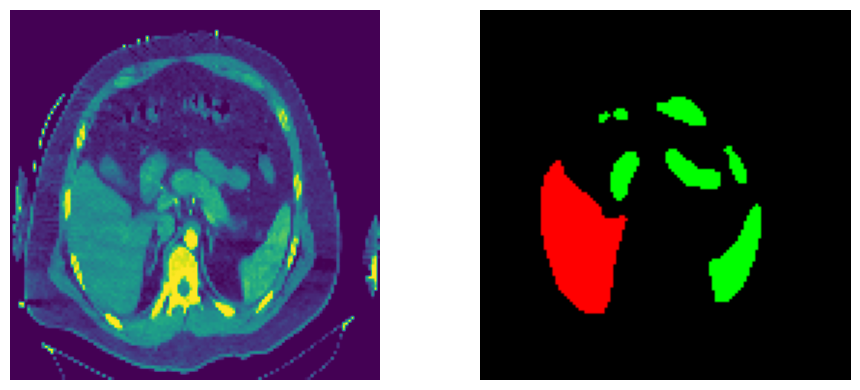

In [8]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 4))

axarr[0].imshow(vis_seg_0)
axarr[0].axis('off') 

axarr[1].imshow(vis_seg_1)
axarr[1].axis('off') 

plt.tight_layout() 
plt.show()

# Postprocess

In [9]:
bowel_w = 2
extrav_w = 6
low_w = 2
high_w = 4

FINAL_SUB = {'patient_id': [], 'bowel_healthy': [], 'bowel_injury': [], 
             'extravasation_healthy': [], 'extravasation_injury': [], 
             'kidney_healthy': [], 'kidney_low': [], 'kidney_high': [],
             'liver_healthy': [], 'liver_low': [], 'liver_high': [],
             'spleen_healthy': [], 'spleen_low': [], 'spleen_high': [],}

for patient in PATIENT_TO_PREDICTION:
    prediction = PATIENT_TO_PREDICTION[patient].copy()
    prediction2 = PATIENT_TO_PREDICTION2[patient].copy()
    
    prediction[9] = (prediction[9] * 0.666) + (prediction2[1]*0.334)
    
    FINAL_SUB['patient_id'].append(patient)
    
    FINAL_SUB['bowel_healthy'].append(1 - prediction[9])
    FINAL_SUB['bowel_injury'].append(prediction[9] * bowel_w)
    FINAL_SUB['extravasation_healthy'].append(1 - prediction2[0])
    FINAL_SUB['extravasation_injury'].append(0.06355258976803305 + (prediction2[0] * extrav_w))
    
    FINAL_SUB['liver_healthy'].append(1 - prediction[0])
    FINAL_SUB['liver_low'].append(prediction[3]*low_w)
    FINAL_SUB['liver_high'].append(prediction[4]*high_w)

    FINAL_SUB['spleen_healthy'].append(1 - prediction[1])
    FINAL_SUB['spleen_low'].append(prediction[5]*low_w)
    FINAL_SUB['spleen_high'].append(prediction[6]*high_w)

    FINAL_SUB['kidney_healthy'].append(1 - prediction[2])
    FINAL_SUB['kidney_low'].append((prediction[7])*low_w)
    FINAL_SUB['kidney_high'].append(prediction[8]*high_w)


In [10]:
import pandas as pd
submission = pd.DataFrame(FINAL_SUB)
submission

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,26501,0.998048,0.003904,0.999315,0.067664,0.996937,0.005558,0.002135,0.989223,0.023738,0.003879,0.992423,0.023016,0.002817


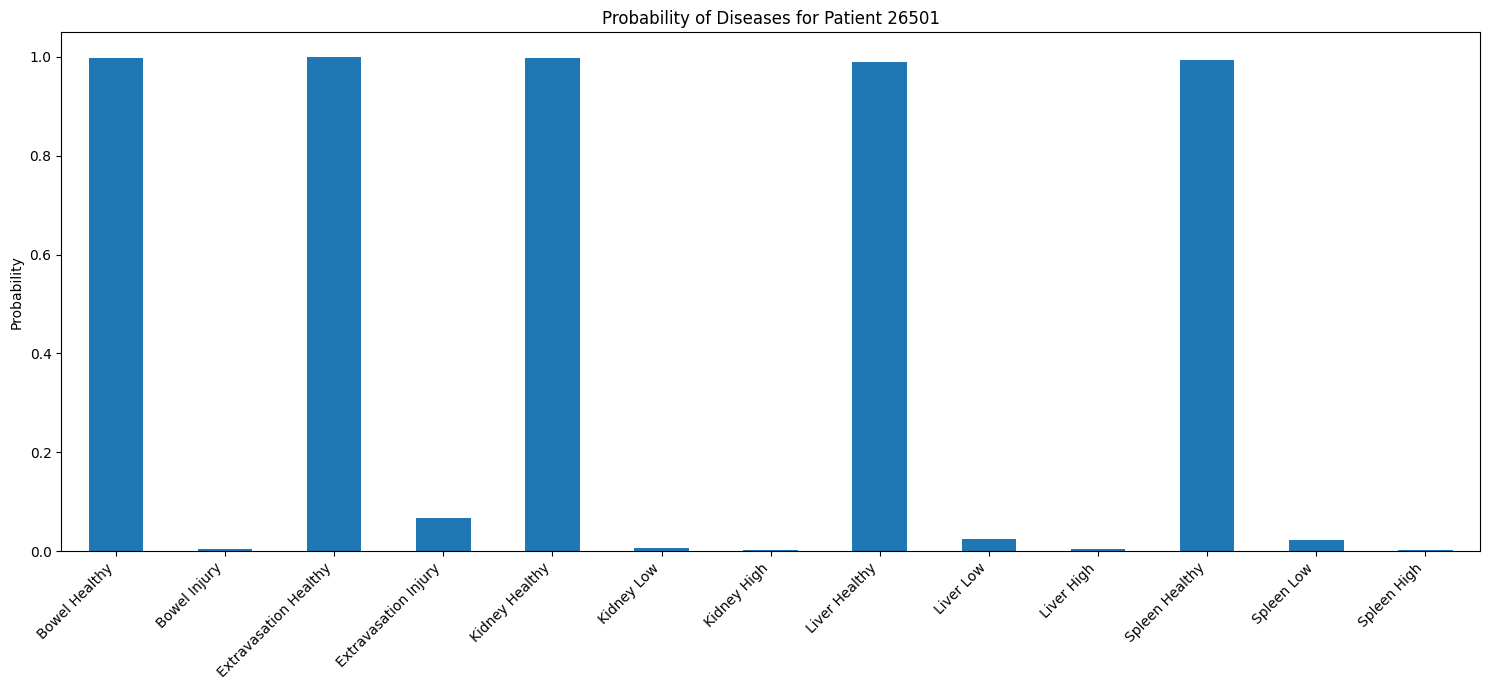

In [11]:
patient_id = submission['patient_id'].iloc[0]
data_to_plot = submission.drop(columns=['patient_id'])
english_column_names = {
    "bowel_healthy": "Bowel Healthy",
    "bowel_injury": "Bowel Injury",
    "extravasation_healthy": "Extravasation Healthy",
    "extravasation_injury": "Extravasation Injury",
    "kidney_healthy": "Kidney Healthy",
    "kidney_low": "Kidney Low",
    "kidney_high": "Kidney High",
    "liver_healthy": "Liver Healthy",
    "liver_low": "Liver Low",
    "liver_high": "Liver High",
    "spleen_healthy": "Spleen Healthy",
    "spleen_low": "Spleen Low",
    "spleen_high": "Spleen High"
}

data_to_plot.columns = [english_column_names[col] for col in data_to_plot.columns]

plt.figure(figsize=(15, 7))
data_to_plot.T.plot(kind='bar', legend=False, ax=plt.gca())
plt.title(f"Probability of Diseases for Patient {patient_id}")
plt.ylabel("Probability")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
!rm -rf /kaggle/working/*

In [13]:
submission.to_csv('./submission.csv', index=False)